In [15]:
import re, os
from src.graph_parameters import GraphParameters
from src.graph_stats import GraphStats
from src.dag_generational_comparison import DAG_GenerationalComparison
from src.dag import DAG
from src.node import Node
from src.edge import Edge
from src.utils import load_dag
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
pkl_stats_re = re.compile('.*P[0-9]*\\\\dag_with_stats.pkl')
data_files = [os.path.join(path, name) for path, _, files in os.walk('.\\data') for name in files]
graph_files = list(filter(pkl_stats_re.match, data_files)) 
print(f"Currently avalible graph with stats files: {graph_files}")

Currently avalible graph with stats files: ['.\\data\\P01\\dag_with_stats.pkl', '.\\data\\P02\\dag_with_stats.pkl', '.\\data\\P03\\dag_with_stats.pkl', '.\\data\\P04\\dag_with_stats.pkl', '.\\data\\P05\\dag_with_stats.pkl', '.\\data\\P06\\dag_with_stats.pkl', '.\\data\\P07\\dag_with_stats.pkl', '.\\data\\P09\\dag_with_stats.pkl', '.\\data\\P10\\dag_with_stats.pkl', '.\\data\\P11\\dag_with_stats.pkl', '.\\data\\P12\\dag_with_stats.pkl', '.\\data\\P13\\dag_with_stats.pkl', '.\\data\\P14\\dag_with_stats.pkl', '.\\data\\P15\\dag_with_stats.pkl', '.\\data\\P16\\dag_with_stats.pkl', '.\\data\\P17\\dag_with_stats.pkl', '.\\data\\P18\\dag_with_stats.pkl', '.\\data\\P19\\dag_with_stats.pkl', '.\\data\\P20\\dag_with_stats.pkl', '.\\data\\P21\\dag_with_stats.pkl', '.\\data\\P23\\dag_with_stats.pkl', '.\\data\\P24\\dag_with_stats.pkl', '.\\data\\P25\\dag_with_stats.pkl', '.\\data\\P26\\dag_with_stats.pkl', '.\\data\\P27\\dag_with_stats.pkl', '.\\data\\P28\\dag_with_stats.pkl', '.\\data\\P30\\dag_w

In [17]:
dags = []

for g in graph_files:
    dag_id = g.split('data\\')[1].split('\\')[0]
    dag = load_dag(g)

    dags.append((dag,dag_id))

In [18]:
exclude = ["P02", "P03", "P10", "P11", "P13", "P24", "P25", "P26", "P30", "P32"]
dags = [x for x in dags if x[1] not in exclude]

In [24]:
dag_names = [d[1] for d in dags]
dag_graphs = [d[0] for d in dags]
print(dag_names)
dag_gen_comparison = DAG_GenerationalComparison(dag_graphs, dag_names, 8)
dag_gen_comparison.compare_diameters(True)

['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P12', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P23', 'P27', 'P28', 'P31', 'P33']


d:\AnalizaParametrowMorfometrycznychNerki\src\dag_generational_comparison.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(axis, xticklabels=self.dag_names)


<Figure size 576x2304 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [20]:
all_edges = [{
    'mean_radius': e['mean_radius'],
    'length': e['length'],
    'relative_angle': e['relative_angle'],
    'tortuosity': e['tortuosity'],
    'interstitial_distance': e['interstitial_distance'],
    'generation': e['generation'],
} for g in dag_graphs for e in g.edges if e['generation'] <= 8]

df = pd.DataFrame(all_edges)
corr = df.dropna().corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,mean_radius,length,relative_angle,tortuosity,interstitial_distance,generation
mean_radius,1.000,0.172,-0.110,-0.049,0.389,-0.469
length,0.172,1.000,-0.052,0.141,0.659,-0.244
relative_angle,-0.110,-0.052,1.000,0.070,-0.196,0.077
tortuosity,-0.049,0.141,0.070,1.000,-0.047,-0.005
interstitial_distance,0.389,0.659,-0.196,-0.047,1.000,-0.304
generation,-0.469,-0.244,0.077,-0.005,-0.304,1.000


,vessels count,total vessel len,vessel avg len,vascular structure vol,vascular network proj area,projection explant area,vascular density,branching points,branching points per pixel,lacunarity
vessels count,1.000,0.988,-0.579,0.198,0.568,0.169,0.699,1.000,0.871,-0.633
total vessel len,0.988,1.000,-0.483,0.276,0.617,0.201,0.741,0.989,0.841,-0.652
vessel avg len,-0.579,-0.483,1.000,0.150,-0.108,0.145,-0.356,-0.576,-0.637,0.438
vascular structure vol,0.198,0.276,0.150,1.000,0.873,0.730,0.665,0.195,-0.214,-0.524
vascular network proj area,0.568,0.617,-0.108,0.873,1.000,0.803,0.766,0.567,0.151,-0.717
projection explant area,0.169,0.201,0.145,0.730,0.803,1.000,0.244,0.169,-0.214,-0.283
vascular density,0.699,0.741,-0.356,0.665,0.766,0.244,1.000,0.697,0.434,-0.866
branching points,1.000,0.989,-0.576,0.195,0.567,0.169,0.697,1.000,0.872,-0.635
branching points per pixel,0.871,0.841,-0.637,-0.214,0.151,-0.214,0.434,0.872,1.000,-0.413
lacunarity,-0.633,-0.652,0.438,-0.524,-0.717,-0.283,-0.866,-0.635,-0.413,1.000


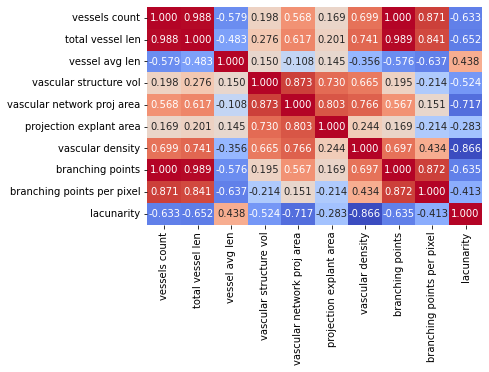

In [21]:
df = pd.read_csv('results/all_dags_stats.csv')

df.columns = [
    'vessels count', 
    'total vessel len', 
    'vessel avg len', 
    'vascular structure vol', 
    'vascular network proj area',
    'projection explant area',
    'vascular density',
    'branching points',
    'branching points per pixel',
    'lacunarity'
]

fig, ax = plt.subplots()
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.3f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png')

corr = df.dropna().corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

In [36]:
df = pd.read_csv('results/all_dags_stats.csv')

df.columns = [
    'vessels count', 
    'total vessel len', 
    'vessel avg len', 
    'vascular structure vol', 
    'vascular network proj area',
    'projection explant area',
    'vascular density',
    'branching points',
    'branching points per pixel',
    'lacunarity'
]
# df[['total vessel len', 'vessels count', 'vessel avg len']].to_csv('test.csv')
from statistics import mean
print(mean(df['vessels count'] / df['branching points']))
# print(df[['vessels count', 'branching points']])

1.0772331176745187
